In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
import os

REPO_NAME = 'sewer-nfl'
CWD = str(os.getcwd())
REPO_DIR = CWD[:CWD.find(REPO_NAME)+len(REPO_NAME)]
sys.path.insert(0,REPO_DIR)

In [4]:
from models._utilities.data.pipe_layer import build_training_dataset

REGEN = True
if REGEN:
    from warehouse.config import Configuration # At model level, swictch this to model's config
    config = Configuration()
    t = build_training_dataset(config)
else: t = build_training_dataset()

2016 done.
2017 done.
2018 done.
2019 done.
2020 done.
2021 done.
2022 done.
Downcasting floats.
Index(['season', 'week', 'team', 'total_off_epa_sum', 'team_HHI'], dtype='object')


c:\Users\zacha\Documents\GitHub\sewer-nfl\models\_utilities\data\pipe_layer.py:76: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  res['missing_N'] = res.isnull().sum(axis=1) / len(res.columns)


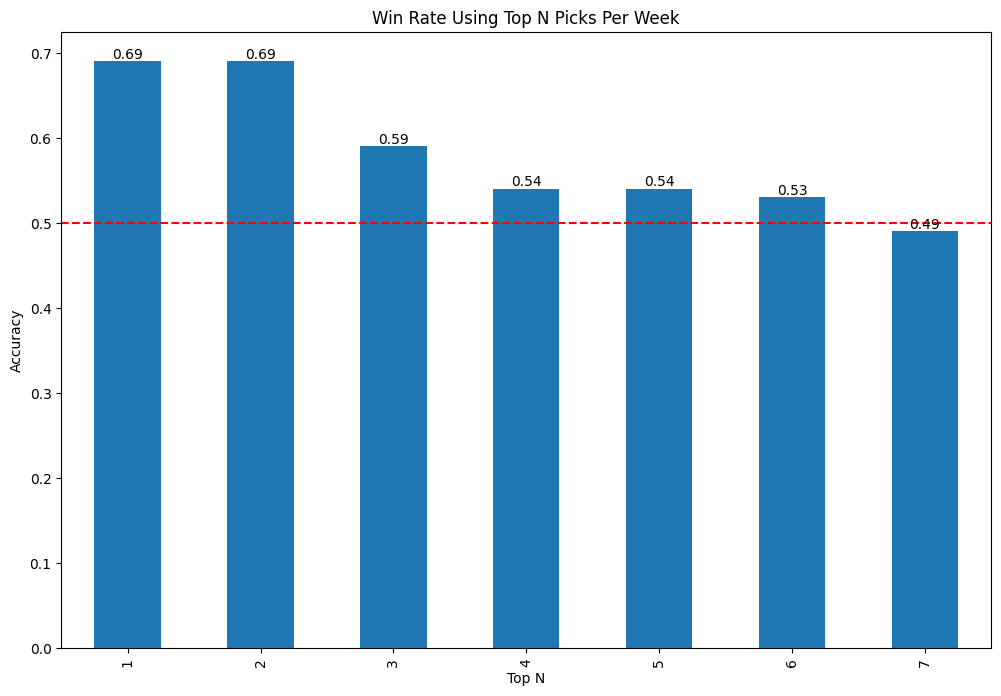

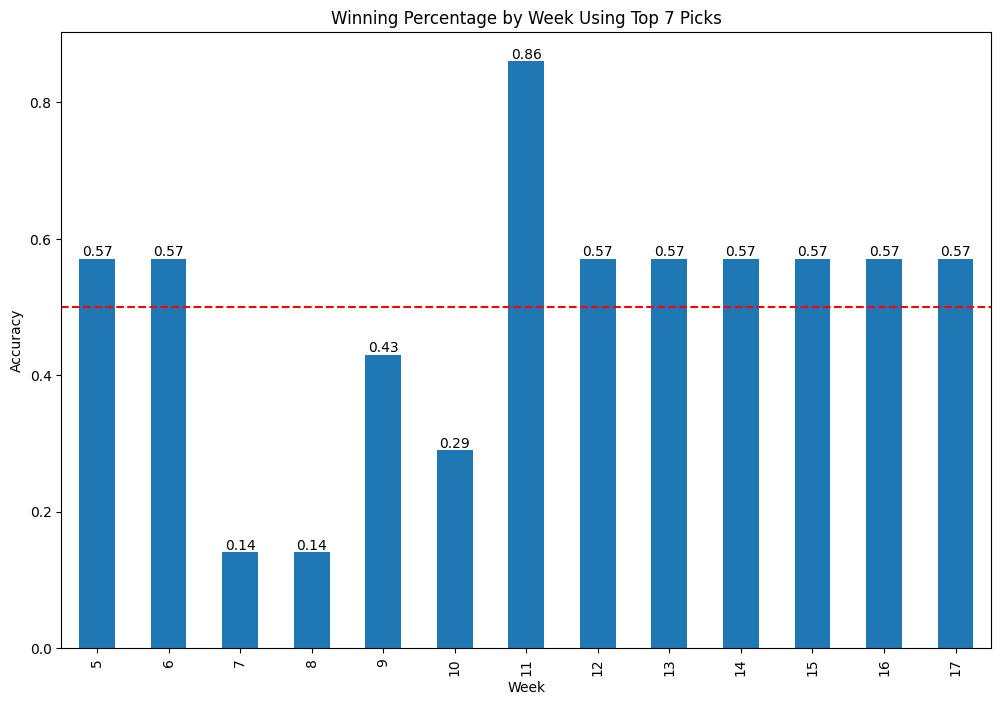

In [6]:
from models._utilities.model.sewer_boost import Model
m1 = Model(
    training_data = t
)
m1.get_test_accuracy_drop_off(top_N_range=range(1,8))
m1.get_test_accuracy_by_week(most_confident=7)

In [7]:
from warehouse.catalog import build_catalog
FUNCTION_CATALOG = build_catalog(config)

In [8]:
from models._utilities.model.sewer_boost import NUMERIC_META_COLS

In [9]:
from warehouse.archive.variable_selection import select_variable_subset

balanced_player_efficacy
off_qb_comp
points_per_drive
overall_coaching
def_qb_comp
def_points_per_drive
def_coaching
def_points_per_RZ
team


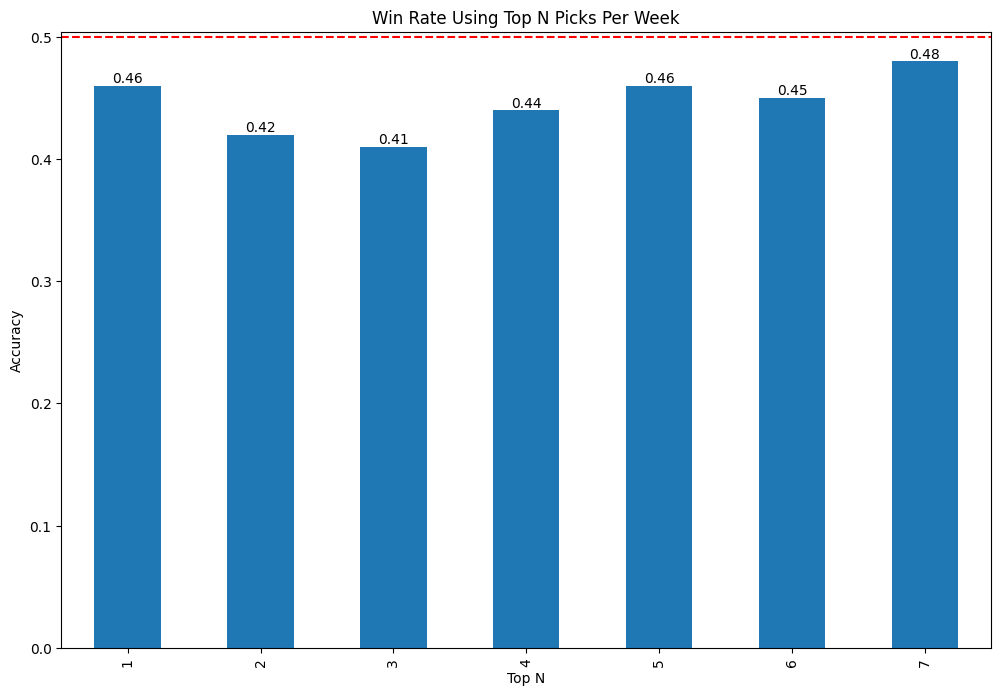

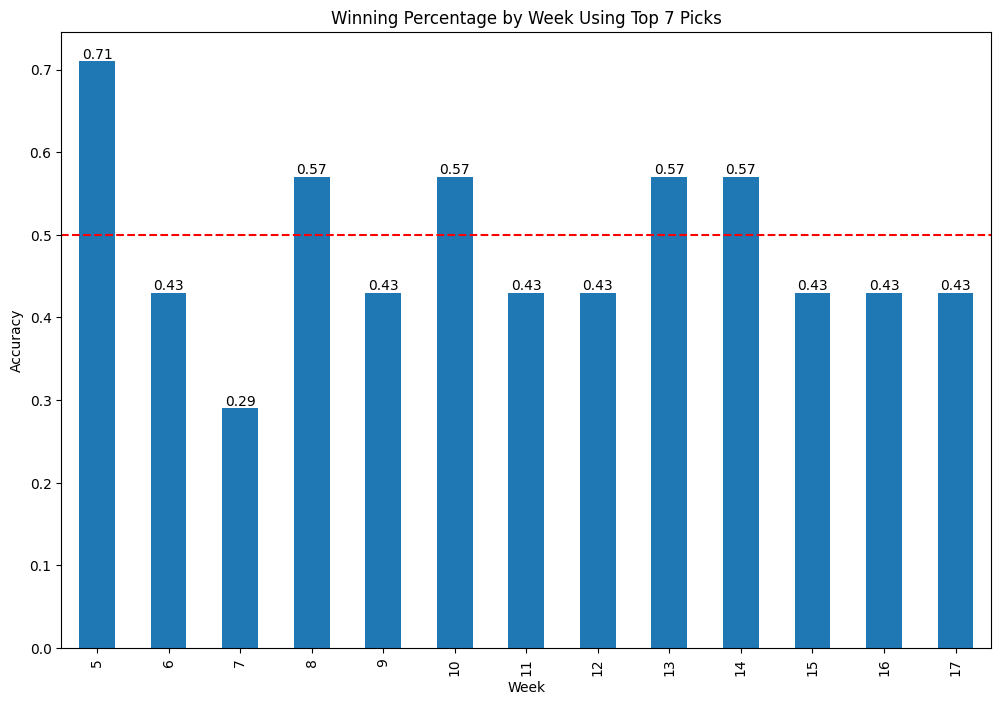

,importance,feature
3,0.080014,away_off_qb_comp
2,0.076879,home_off_qb_comp
11,0.072516,away_def_points_per_drive
14,0.071552,home_def_points_per_RZ
9,0.068355,away_def_qb_comp
8,0.065542,home_def_qb_comp
7,0.063523,away_overall_coaching
6,0.062776,home_overall_coaching
13,0.059014,away_def_coaching
4,0.058182,home_points_per_drive


In [10]:
vars = select_variable_subset(FUNCTION_CATALOG=FUNCTION_CATALOG, total_variables=8) + ['team']
vars2 = [item for sublist in [[f'home_{v}',f'away_{v}'] for v in vars] for item in sublist]
vars2.extend(NUMERIC_META_COLS)

print('\n'.join(vars))

t2 = t[vars2]
m2 = Model(
    training_data = t2,
    params = {
            'objective':'binary:logistic',
            'gamma':0.4,
            'learning_rate':0.005,
            'max_depth':10,
            'n_estimators':100,
            'tree_method':'hist',
            'grow_policy': 'lossguide',
            'reg_alpha': 0.5,
            'reg_lambda': 0.5
        }
)
m2.get_test_accuracy_drop_off(top_N_range=range(1,8))
m2.get_test_accuracy_by_week(most_confident=7)
m2.assess_predictor_importance()

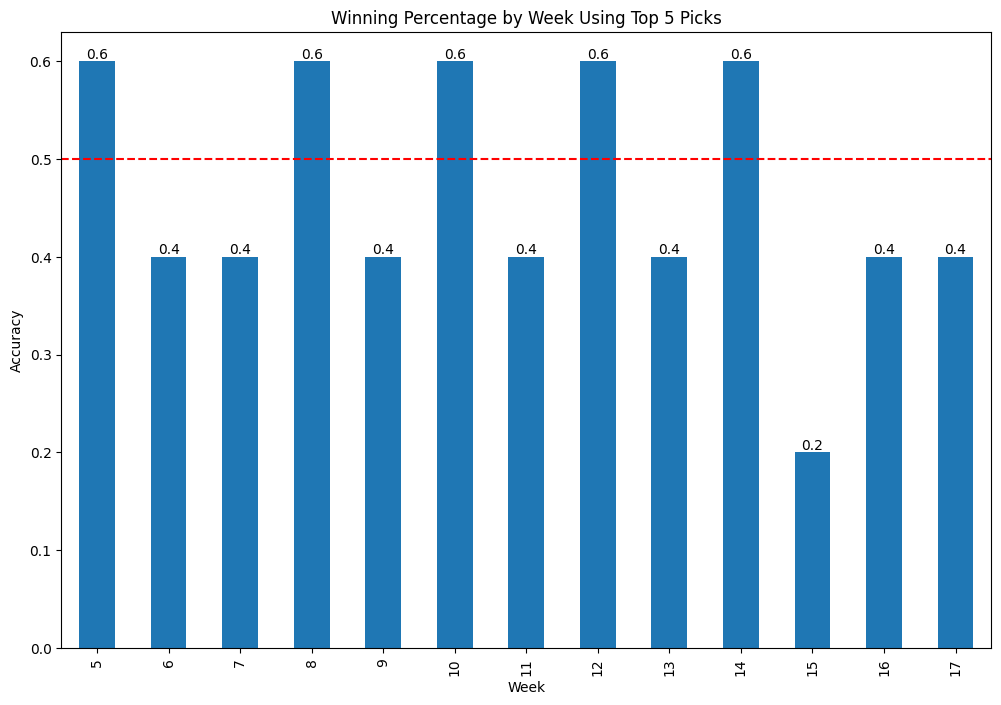

In [11]:
m2.get_test_accuracy_by_week(most_confident=5)

In [12]:
from models._utilities.model.sewer_builder import Sewer

Using cache


In [13]:
s = Sewer(
    FUNCTION_CATALOG=FUNCTION_CATALOG,
    batch_size=10
)
s.generate(verbose = True)

5
10
Assembling comparison rows


In [19]:
s.promote()

Registered model as 20230714003326_tbivn


In [20]:
import pickle
pickle.load(open(f'{REPO_DIR}/models/_registry/20230714003326_tbivn.pkl','rb'))

TypeError: file must have 'read' and 'readline' attributes